# NLP Challenge: IMDB Dataset Sentiment Analysis

This project involves solving a classification problem on movie review data. Movie reviews in this dataset have two sentiment -- positive or negative. The goal is to train ML models that can classify movie reviews into the correct category.

## Data Exploration

Before model training, we will conduct some EDA.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
print(df.info(), '\n')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None 

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


In [5]:
# Check for missing values, duplicates, and class balance
print(df.isnull().sum(), '\n')
print(df.duplicated().sum(), '\n')
print(df['sentiment'].value_counts())

review       0
sentiment    0
dtype: int64 

418 

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [6]:
# Check duplicate reviews
print(df[df.duplicated('review')])

                                                  review sentiment
3537   Quite what the producers of this appalling ada...  negative
3769   My favourite police series of all time turns t...  positive
4391   Beautiful film, pure Cassavetes style. Gena Ro...  positive
6352   If you liked the Grinch movie... go watch that...  negative
6479   I want very much to believe that the above quo...  negative
...                                                  ...       ...
49912  This is an incredible piece of drama and power...  positive
49950  This was a very brief episode that appeared in...  negative
49984  Hello it is I Derrick Cannon and I welcome you...  negative
49986  This movie is a disgrace to the Major League F...  negative
49991  Les Visiteurs, the first movie about the medie...  negative

[418 rows x 2 columns]


In [7]:
# Remove duplicates
df.drop_duplicates(inplace=True)
print(df['sentiment'].value_counts())

sentiment
positive    24884
negative    24698
Name: count, dtype: int64


**Notes from preliminary EDA**

1. Size: Dataset contains 50,000 entries
2. Missing Values: Dataset contains no missing values.
3. Duplicates: Dataset contains 418 duplicates, which we can remove for a more robust dataset.
4. Balance: Dataset is evenly balanced, with ~25,000 positive and negtative review (after dropping duplicates)

## Data Preprocessing

Since we are dealing with raw text data, we will have to take some steps to preprocess the data for model training. Before splitting the data into testing and training sets, we will take the following steps:

1. Remove special characters, HTML tags, etc.
2. Transform words to lowercase
3. Tokenize words
4. Remove stop words and add stemming using NLTK
5. Transform text data into TF-IDF (term frequency-inverse document frequency) vector so that it can be interpretted by ML models

To do the above, we will utilize the NLTK module for stop word removal, stemming, and tokenization, and use sk-learn for tf-idf vectorization.

After the data is processed, we'll split the data into a training set (75%) and testing set (25%)

In [8]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [9]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\owenc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\owenc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
# Define stopwords and initialize stemmer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# Define function to preprocess text
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-letters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and stem
    words = [ps.stem(w) for w in words if w not in stop_words]
    return ' '.join(words)

# Preprocess test in df
df['review'] = df['review'].apply(preprocess_text)
df.head()

,review,sentiment
0,one review mention watch oz episod hook right ...,positive
1,wonder littl product film techniqu unassum old...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic famili littl boy jake think zombi closet...,negative
4,petter mattei love time money visual stun film...,positive


Observing the first few entries in the updated df, we see that:

- all text is lowercased
- no apparent HTML tags, special characters, etc.
- text has been stemmed

From here, we will use TfIdfVectorizer to fit and transform the preprocessed reviews. This will convert the raw text data into a vector of numerical TF-IDF features. This reflects the importance of a specific word relative to the document in a collection.

By fitting the vectorizer on the review column, it will learn the vocabulary of the dataset. This process transforms the text data into a numerical vector that can be interpreted by ML models.

The importance of this step is that it converts the unstructured text data into a structed form that can be used as input to the ML models. By using the vectorizer, we can convert the text data into numerical data while still preserving the semantic relationship between words in the dataset.

In [11]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer
X = vectorizer.fit_transform(df['review'])

# Map the sentiment to binary
y = df['sentiment'].map({'positive': 1, 'negative': 0})

Now that we have our X (features) and y (target) defined, we can split the data into training (75%) and testing (25%) sets.

In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Data Modeling

We will implement the following ML models to classify the data:

1. Logistic Regression
2. LinearSVC
3. KNN
4. Random Forest

After, we will evaluate the performance by comparing accuracy, precision, recall, and f1-score of each model.

### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize model
lr_model = LogisticRegression()

# Fit model
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      6168
           1       0.88      0.91      0.89      6228

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396



### LinearSVC (Support vector classifier)

In [14]:
from sklearn.svm import LinearSVC

# Initialize model
svm_model = LinearSVC(random_state=42)

# Fit model
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred = svm_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

c:\Users\owenc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6168
           1       0.88      0.90      0.89      6228

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396



### KNeighbors Classifier

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize model
knn_model = KNeighborsClassifier()

# Fit model
knn_model.fit(X_train, y_train)

# Predict on test set
y_pred = knn_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76      6168
           1       0.74      0.84      0.79      6228

    accuracy                           0.77     12396
   macro avg       0.78      0.77      0.77     12396
weighted avg       0.78      0.77      0.77     12396



### Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# Fit model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      6168
           1       0.84      0.85      0.85      6228

    accuracy                           0.84     12396
   macro avg       0.84      0.84      0.84     12396
weighted avg       0.84      0.84      0.84     12396



### Hyperparameter Tuning

After getting a baseline for each of the models, we'll now attempt to optimize each model by using gridsearch to tune the hyperparameters.

To do so, we will define a grid of hyperparameters specific to each model. Then, we'll take the best performing hyperparams and evaluate the results.

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# Define hyperparameter grids
# Logistic Regression
lr_param_grid = {'C': [0.1, 1, 10]} # Regularization parameter

# Linear SVC
svm_param_grid = {'C': [0.1, 1, 10]} # Regularization parameter

# KNN
knn_param_grid = {'n_neighbors': [3, 5, 7]} # Number of neighbors

# Random Forest
rf_param_grid = {'n_estimators': [100, 200, 300]} # Number of estimators

In [18]:
# Optimizing models using gridsearch
# Logistic Regression
lr_grid_search = GridSearchCV(lr_model, lr_param_grid)
lr_grid_search.fit(X_train, y_train)
lr_best_model = lr_grid_search.best_estimator_
print(lr_best_model)
y_pred_lr = lr_best_model.predict(X_test)

# Linear SVC
svm_grid_search = GridSearchCV(svm_model, svm_param_grid)
svm_grid_search.fit(X_train, y_train)
svm_best_model = svm_grid_search.best_estimator_
print(svm_best_model)
y_pred_svm = svm_best_model.predict(X_test)

# KNN
knn_grid_search = GridSearchCV(knn_model, knn_param_grid)
knn_grid_search.fit(X_train, y_train)
knn_best_model = knn_grid_search.best_estimator_
print(knn_best_model)
y_pred_knn = knn_best_model.predict(X_test)

# Random Forest
rf_grid_search = GridSearchCV(rf_model, rf_param_grid)
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_
print(rf_best_model)
y_pred_rf = rf_best_model.predict(X_test)

# Print classification reports
print('Logistic Regression\n', classification_report(y_test, y_pred_lr))
print('Linear SVC\n', classification_report(y_test, y_pred_svm))
print('KNN\n', classification_report(y_test, y_pred_knn))
print('Random Forest\n', classification_report(y_test, y_pred_rf))

LogisticRegression(C=1)


c:\Users\owenc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\owenc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\owenc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\owenc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\owenc\anaconda3\Lib\site-packages\sklearn\svm\_clas

LinearSVC(C=0.1, random_state=42)
KNeighborsClassifier(n_neighbors=7)
RandomForestClassifier(n_estimators=300, random_state=42)
Logistic Regression
               precision    recall  f1-score   support

           0       0.90      0.87      0.89      6168
           1       0.88      0.91      0.89      6228

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396

Linear SVC
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      6168
           1       0.88      0.91      0.89      6228

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396

KNN
               precision    recall  f1-score   support

           0       0.83      0.71      0.76      6168
           1       0.75      0.85      0.80      6228

    accuracy    

In [17]:
# Retraining best models due to kernel restart
# Logistic Regression
lr_best_model = LogisticRegression(C=10)
lr_best_model.fit(X_train, y_train)
y_pred_lr = lr_best_model.predict(X_test)

# Linear SVC
svm_best_model = LinearSVC(C=1, random_state=42)
svm_best_model.fit(X_train, y_train)
y_pred_svm = svm_best_model.predict(X_test)

# KNN
knn_best_model = KNeighborsClassifier(n_neighbors=7)
knn_best_model.fit(X_train, y_train)
y_pred_knn = knn_best_model.predict(X_test)

# Random Forest
rf_best_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_best_model.fit(X_train, y_train)
y_pred_rf = rf_best_model.predict(X_test)

c:\Users\owenc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [18]:
# Print classification reports
print('Logistic Regression\n', classification_report(y_test, y_pred_lr))
print('Linear SVC\n', classification_report(y_test, y_pred_svm))
print('KNN\n', classification_report(y_test, y_pred_knn))
print('Random Forest\n', classification_report(y_test, y_pred_rf))

Logistic Regression
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      6168
           1       0.88      0.90      0.89      6228

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396

Linear SVC
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      6168
           1       0.88      0.90      0.89      6228

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396

KNN
               precision    recall  f1-score   support

           0       0.83      0.71      0.76      6168
           1       0.75      0.85      0.80      6228

    accuracy                           0.78     12396
   macro avg       0.79      0.78      0.78     12396
weighted avg       0.79      0.78   

## Results

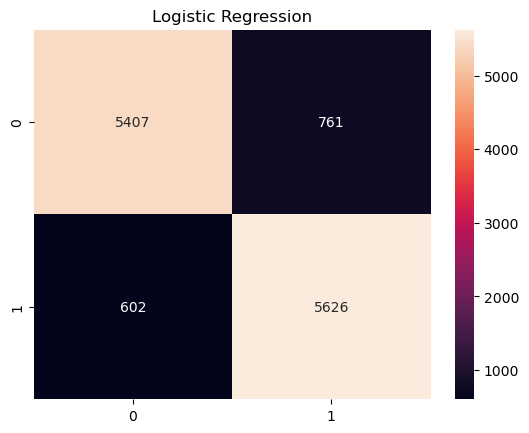

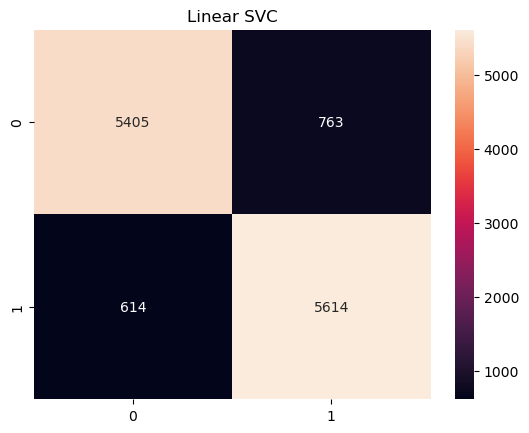

In [21]:
# Plotting confusion matrices for logistic regression and linear SVC, the two best models
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Logistic Regression
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Logistic Regression')
plt.show()

# Linear SVC
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Linear SVC')
plt.show()

Based on varying metrics like accuracy, recall, precision, and by looking at the confusion matrices, we can determine that logistic regression and linear SVC were the two best performing models. This makes sense as these models are best for working with text data. We were able to train models which can classify the sentiment of a movie review with 89% accuracy -- so there is still room for improvement.

In the future, it might be beneficial to implement a deep neural network as this might be able to better capture the semantical relationships between words in a review. However for the sake of this challenge, the simpler ML models will give us sufficient results.

## User Testing

Finally, to show the functionality of the program, a user is able to input a custom review to check the accuracy of the models. The input will be preprocessed and each model will predict the sentiment of the inputted review.

In [28]:
review = input("Enter a review. Type 'q' to exit: ")

while review != 'q':
    print(f'Review: {review}')

    # Preprocess the review
    review = preprocess_text(review)

    # Convert the review into Tfidf form
    review = vectorizer.transform([review])

    # Make predictions for each model
    lr_pred = lr_best_model.predict(review)
    svm_pred = svm_best_model.predict(review)
    knn_pred = knn_best_model.predict(review)
    rf_pred = rf_best_model.predict(review)

    # Print the predictions
    print(f'Logistic Regression: {"Positive" if lr_pred[0] == 1 else "Negative"}')
    print(f'Linear SVC: {"Positive" if svm_pred[0] == 1 else "Negative"}')
    print(f'KNN: {"Positive" if knn_pred[0] == 1 else "Negative"}')
    print(f'Random Forest: {"Positive" if rf_pred[0] == 1 else "Negative"}\n')

    review = input("Enter a review. Type 'q' to exit: ")

Review: this was a good movie
Logistic Regression: Positive
Linear SVC: Positive
KNN: Positive
Random Forest: Positive

Review: this was a bad movie
Logistic Regression: Negative
Linear SVC: Negative
KNN: Negative
Random Forest: Negative

Review: 
Logistic Regression: Negative
Linear SVC: Negative
KNN: Negative
Random Forest: Positive

